# 实现TF-IDF

这里我们实现TF-IDF（Text Frequency - Inverse Document Frequency），来处理spam-ham文本数据。

我们基于scikit学习的TFIDF向量化工具使用混合方法来编码文本。然后我们将使用通用Tensorflow逻辑算法。

在我们开始训练模型之前，创建TF-IDF向量需要我们载入所有的文本到内存当中并且计算每个词出现的次数。因为这些，在Tensorflow中并没有完全实现，因此我们将使用scikit-learn工具来实现我们的TF-IDF词嵌入，而使用Tensorflow来实现逻辑模型。

# 实现TF-IDF（理解算法原理和实现细节）

TF-IDF是Text Frequency – Inverse Document Frequency的缩写表示。该项表示每个词的文本频率和逆向文档频率的乘积。

在先前的教程中，我介绍了一种词嵌入方法，该方法在每个句子中按照每个词出现的次数赋予一个1的值。对于每一类句子这种方法处理的并不理想（先前的例子中的spam和ham），比如出现了很多相同频率的“the”、"and"和其他词，然而像“viagra"和“sale”的词应该提高重要形，来表示文本是否为广告。

我们首先想到计算词的频率。这里我们在单个入口一个词出现的频率。该部分(TF)的目的，是在每个入口找到那个部分是重要的。但是像"the"和"and"这样的词在每个段落中是非常常见的。我们希望降低这些词的权重，因此我们想通过真个文档频率的逆来乘以上面的文本频率，这样做可以帮忙找到重要的单词。由于整个文本比较大，一般使用逆文档频率的对数值。我们在每个文档入口内的每个句子，使用下面的公式来计算TF-IDF。

$$
w_{tf-idf}=w_{tf} \cdot \frac{1}{log(w_{df})}
$$

其中$w_{tf}$是文档的词频，并且$w_{df}$是所有文档的全部词频。我们认为TF-IDF越大，则该词对于我们的文档越重要。

创建TF-IDF向量需要我们将所有的文本都加载到内存中，以及在我们开始训练模型之前要计算每个词的出现频率。因为这些，在Tensorflow中并没有完全实现，因此我们使用Scikit-learn软件包来创建我们的TF-IDF词嵌入，然后用Tensorflow来拟合逻辑回归模型。

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import string
import requests
import io
import nltk
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.framework import ops
ops.reset_default_graph()

/home/zhangxin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


开启计算图会话

In [2]:
sess = tf.Session()

我们设置两个参数，`batch_size`和`max_feature`。其中`batch_size`是批尺寸大小，这个参数将用于逻辑回归模型的训练，而`max_features`是TF-IDF文本词语的最大数量，其也会在逻辑回归中使用。

In [3]:
batch_size = 200
max_features = 1000

检查数据是否已下载，否则下载数据并且保存以后用

In [4]:
save_file_name = 'temp_spam_data.csv'
if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # 格式化数据
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    # 将数据写入文件
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

我们现在清洗数据。通过将字母变为小写字母、移除符号和数字，减小字典的大小。

In [7]:
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

# 将spam文本标记为1，非spam文本标记为0
target = [1. if x=='spam' else 0. for x in target]

# 规则化文本，就是将文本变为小写格式
texts = [x.lower() for x in texts]

# 移除符号
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# 移除数字
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# 移除多余的空格
texts = [' '.join(x.split()) for x in texts]

Define tokenizer function and create the TF-IDF vectors with SciKit-Learn.

In [9]:
nltk.download('punkt')

def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

# 创建文本的TF-IDF
tfidf = TfidfVectorizer(tokenizer=tokenizer, 
                        stop_words='english', 
                        max_features=max_features)
sparse_tfidf_texts = tfidf.fit_transform(texts)

[nltk_data] Downloading package punkt to /home/zhangxin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


将数据划分为训练和测试集。

In [10]:
train_indices = np.random.choice(sparse_tfidf_texts.shape[0], 
                                 round(0.8*sparse_tfidf_texts.shape[0]), replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) - set(train_indices)))
texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

现在我们创建用于逻辑回归的变量和占位符。然后我们声明逻辑回归的运算。需要注意的是sigmoid操作是在损失函数中进行的。

In [11]:
# 创建变量
A = tf.Variable(tf.random_normal(shape=[max_features,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# 占位符
x_data = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# 声明逻辑模型（sigmoid在损失函数中）
model_output = tf.add(tf.matmul(x_data, A), b)

接下来我们声明损失函数（其中包含sigmoid操作），当然预测函数中也会有sigmoid运算。在预测函数中需要增加sigmoid运算，因为在模型建立的时候没有加入sigmoid函数。

In [12]:
# 声明损失函数（交叉熵损失）
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# 预测
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

创建优化器和初始化模型变量

In [13]:
# 声明优化器
my_opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_opt.minimize(loss)

# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

最终，我们在1000个TF-IDF特征中执行我们的逻辑回归训练。

In [14]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size=batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # 每100测迭代记录损失和准确率
    if (i+1)%100==0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 500. Train Loss (Test Loss): 0.59 (0.60). Train Acc (Test Acc): 0.72 (0.69)
Generation # 1000. Train Loss (Test Loss): 0.57 (0.56). Train Acc (Test Acc): 0.72 (0.73)
Generation # 1500. Train Loss (Test Loss): 0.63 (0.53). Train Acc (Test Acc): 0.68 (0.77)
Generation # 2000. Train Loss (Test Loss): 0.55 (0.51). Train Acc (Test Acc): 0.75 (0.79)
Generation # 2500. Train Loss (Test Loss): 0.51 (0.50). Train Acc (Test Acc): 0.81 (0.81)
Generation # 3000. Train Loss (Test Loss): 0.39 (0.50). Train Acc (Test Acc): 0.88 (0.82)
Generation # 3500. Train Loss (Test Loss): 0.50 (0.49). Train Acc (Test Acc): 0.83 (0.83)
Generation # 4000. Train Loss (Test Loss): 0.45 (0.49). Train Acc (Test Acc): 0.85 (0.83)
Generation # 4500. Train Loss (Test Loss): 0.42 (0.48). Train Acc (Test Acc): 0.88 (0.83)
Generation # 5000. Train Loss (Test Loss): 0.48 (0.48). Train Acc (Test Acc): 0.86 (0.83)
Generation # 5500. Train Loss (Test Loss): 0.46 (0.48). Train Acc (Test Acc): 0.84 (0.84)
Generation 

这里使用matplotlib代码画出损失和准确率。

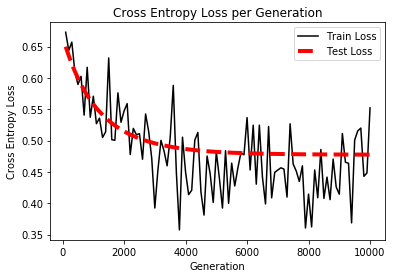

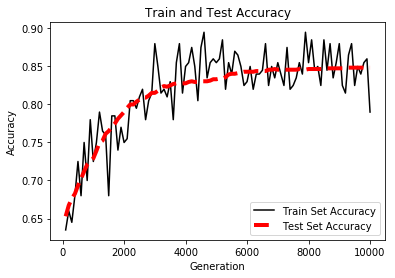

In [15]:
# 画出损失随时间变化关系
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# 画出训练和测试准确率随时间变化关系
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()